In [378]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler


# Questions for Professor:
* Batch Size... I have 1826 rows in total... It is set to 20?
* There is no "accuracy" because of the regression and that the results are integers sales?
* The Loss is extremly low... WHy would this be the case?
* I'm not sure I understand the concept of the sequence length
* On the `forward` method of the model I use:
  ```
    h0 = torch.zeros(num_layers, y.size(0), hidden_size).to(y.device)
    c0 = torch.zeros(num_layers, y.size(0), hidden_size).to(y.device)
  ```
* I somehow had a hard time creating the LSTM network and then adding it to the model.. Will need to work on that some but is it ok?
* ~How would I try to "un-scale" the values to plot the prediction vs. the validation values?~
* Is dropout a good idea?
* I used "4" for the stacked LSTM layers... is that overkill and should I just stay with "1"?
* Overall... is the the right approach for this project? It seems a bit general and I havent really contributed to anything meaninful...

In [379]:
# Config & Setup Details
cfg_batch_size  = 150
cfg_max_epochs  = 150
cfg_num_workers = 2

# Learning Config
cfg_split        = 0.8
cfg_sequence_len = 180

# Data Config
cfg_data_separator = ","
cfg_data_date_fmt  = "%Y-%m-%d"
cfg_data_url_train = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "Project"
cfg_logger_version = "data-loader"


In [380]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

NVIDIA GeForce RTX 2080 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Number of devices: 1


In [381]:
# Load Data - Parse the Date Column
df_raw = pd.read_csv(cfg_data_url_train, parse_dates=["date"])

print(f"Raw Shape: {df_raw.shape}")
print(df_raw.head())
print("********\n")

# Format Date Column to DateTime
df_raw['date'] = pd.to_datetime(df_raw['date'], format=cfg_data_date_fmt)

df_grouped_date_store = df_raw.groupby(['date', 'store'])['sales'].sum().reset_index()
df_grouped_date = df_raw.groupby(['date'])['sales'].sum().reset_index()

print(f"Grouped by Date Shape: {df_grouped_date.shape}")
print(df_grouped_date)
print("********\n")

print(f"Grouped by Date & Store Shape: {df_grouped_date_store.shape}")
print(df_grouped_date_store)
print("********\n")

# Pivot the DataFrame
df_train = df_grouped_date_store.pivot(index='date', columns='store', values='sales')

# Resetting the index
df_train = df_train.reset_index()

# Show the New Table
print(f"Training Shape: {df_train.shape}")
print(df_train)
print(f"Training Cols: {df_train.columns}")
print("********\n")



Raw Shape: (913000, 4)
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
********

Grouped by Date Shape: (1826, 2)
           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]
********

Grouped by Date & Store Shape: (18260, 3)
            date  store  sales
0     2013-01-01      1   1316
1     2013-01-01      2   1742
2     2013-01-01      3   1588
3     2013-01-01      4   1423
4     2013-01-01      5   1032
...          ...    ...    ...
18255 2017-12-31      6   2009
18256 2017-12-31      7   1831
18257 2017-12-31      8   3205
18258 2017-12-31      9   2774
18259 2017-12-31     10   2939

[18260 row

In [382]:
df_avg = df_train

# Recalculating moving average for each numerical column
for col in range(1, 11):  # Assuming columns are named as 1, 2, ..., 10
    df_avg[col] = df_avg[col].rolling(window=7, min_periods=1).mean()

# Displaying the updated DataFrame with moving averages
df_avg.head(10) 

store,date,1,2,3,4,5,6,7,8,9,10
0,2013-01-01,1316.000000,1742.000000,1588.000000,1423.000000,1032.000000,1099.000000,964.000000,1628.000000,1383.000000,1521.000000
1,2013-01-02,1290.000000,1775.000000,1563.000000,1427.500000,1014.500000,1061.000000,954.000000,1657.500000,1419.000000,1525.500000
2,2013-01-03,1295.000000,1812.333333,1587.000000,1463.000000,1053.000000,1090.333333,958.000000,1683.666667,1443.333333,1568.333333
3,2013-01-04,1334.250000,1855.000000,1625.500000,1518.500000,1104.250000,1118.000000,978.500000,1754.250000,1485.500000,1611.000000
4,2013-01-05,1367.200000,1901.400000,1677.800000,1544.600000,1114.200000,1151.600000,1009.000000,1804.400000,1528.000000,1657.000000
5,2013-01-06,1408.166667,1952.166667,1724.166667,1608.333333,1139.333333,1186.166667,1039.666667,1851.166667,1570.166667,1698.500000
6,2013-01-07,1351.571429,1887.000000,1665.428571,1559.714286,1100.571429,1146.428571,1004.000000,1812.000000,1519.000000,1645.142857
7,2013-01-08,1339.000000,1895.285714,1658.285714,1560.857143,1094.857143,1132.571429,999.428571,1817.285714,1527.714286,1646.142857
8,2013-01-09,1336.000000,1892.142857,1671.857143,1566.428571,1101.714286,1132.857143,1004.428571,1817.571429,1520.000000,1657.000000
9,2013-01-10,1340.857143,1902.000000,1677.857143,1558.000000,1106.857143,1136.857143,1008.714286,1816.428571,1527.857143,1646.571429


In [383]:
# Setup the Dataframe being used
df = df_avg # Simple Copy
df.set_index('date', inplace=True)
print(f"DF Shape: {df.shape}")

DF Shape: (1826, 10)


In [384]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Create sequences
x, y = create_sequences(df.values, cfg_sequence_len)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training and testing sets
train_size = int(cfg_split * len(x_tensor))

x_train = x_tensor[:train_size]
y_train = y_tensor[:train_size]

x_val = x_tensor[train_size:]
y_val = y_tensor[train_size:]

In [385]:
print(f"x Shape: {x.shape}")
print(f"y Shape: {y.shape}")
print("")
print(f"x_train Shape: {x_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print("")
print(f"x_val Shape: {x_val.shape}")
print(f"y_val Shape: {y_val.shape}")

x Shape: (1646, 180, 10)
y Shape: (1646, 10)

x_train Shape: torch.Size([1316, 180, 10])
y_train Shape: torch.Size([1316, 10])

x_val Shape: torch.Size([330, 180, 10])
y_val Shape: torch.Size([330, 10])


In [436]:
class LSTMModel(pl.LightningModule):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 num_layers,
                 scaler = 1500,
                 **kwargs):
        super().__init__(**kwargs)

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.linear = nn.Linear(hidden_size, output_size)
        self.loss = nn.MSELoss()
        self.scaler = scaler

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.002)
        return optimizer

    # No complications with regression...
    def predict(self, x):
        return self(x)
    
    def forward(self, x):
        y = x / self.scaler
        #y = torch.log(y)
        y, _ = self.lstm(y)
        y = y[:, -1, :] # Extract only the last time step
        y = self.linear(y) # Using linear to bring back to output_size
        #y = torch.exp(y)
        
        return y * self.scaler

    def training_step(self, train_batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y_true = train_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)

        offset = y_true.sum() - y_pred.sum()
        self.log('train_offset', offset, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        offset = y_true.sum() - y_pred.sum()
        self.log('val_offset', offset, on_step=False, on_epoch=True)
        
        return loss


# Model parameters
input_size  = 10 # Number of features (sales data from 10 stores)
hidden_size = 50 # Number of features in hidden state
output_size = 10 # Number of output values (future sales prediction)
num_layers  = 4  # Number of stacked LSTM layers

# Create the LSTM model
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

In [437]:
summary(model, input_data=torch.Tensor(x_train[0:5]).float())

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [5, 10]                   --
├─LSTM: 1-1                              [5, 180, 50]              73,600
├─Linear: 1-2                            [5, 10]                   510
Total params: 74,110
Trainable params: 74,110
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 66.24
Input size (MB): 11.85
Forward/backward pass size (MB): 0.36
Params size (MB): 0.30
Estimated Total Size (MB): 12.51

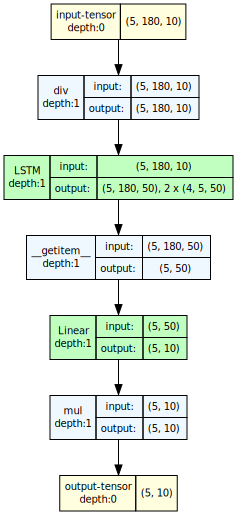

In [438]:
model_graph = draw_graph(model,
                         input_data=torch.Tensor(x_train[0:5]).float(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])

model_graph.visual_graph

In [439]:
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_train).float(),
                                                torch.Tensor(y_train).float())), 
                                       shuffle=True, 
                                       batch_size=cfg_batch_size, 
                                       num_workers=cfg_num_workers)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_val).float(), 
                                              torch.Tensor(y_val).float())), 
                                     shuffle=False, 
                                     batch_size=cfg_batch_size, 
                                     num_workers=cfg_num_workers)

In [440]:
logger = pl.loggers.CSVLogger("lightning_logs", 
                              name="Project",
                              version="1.0.0")

In [441]:
trainer = pl.Trainer(logger=logger, max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [442]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning:

Experiment logs directory lightning_logs/Project/1.0.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │         9598987.0         │
│        val_offset         │         4241256.5         │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 9598987.0, 'val_offset': 4241256.5}]

In [443]:
trainer.fit(model, xy_train, xy_val) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | lstm    | LSTM      | 73.6 K
1 | dropout | Dropout1d | 0     
2 | linear  | Linear    | 510   
3 | loss    | MSELoss   | 0     
--------------------------------------
74.1 K    Trainable params
0         Non-trainable params
74.1 K    Total params
0.296     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [444]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_loss,val_offset,epoch,step,train_loss,train_offset
0,9.598987e+06,4.241256e+06,0,0,NaN,NaN
1,5.357439e+06,3.128178e+06,0,8,NaN,NaN
2,NaN,NaN,0,8,6.057014e+06,3.456244e+06
3,6.817724e+05,6.403737e+05,1,17,NaN,NaN
4,NaN,NaN,1,17,1.678460e+06,1.312021e+06
...,...,...,...,...,...,...
296,NaN,NaN,147,1331,2.886690e+03,-8.803762e+02
297,3.284955e+03,3.319518e+04,148,1340,NaN,NaN
298,NaN,NaN,148,1340,2.762894e+03,-4.361265e+02
299,2.895383e+03,8.223103e+03,149,1349,NaN,NaN


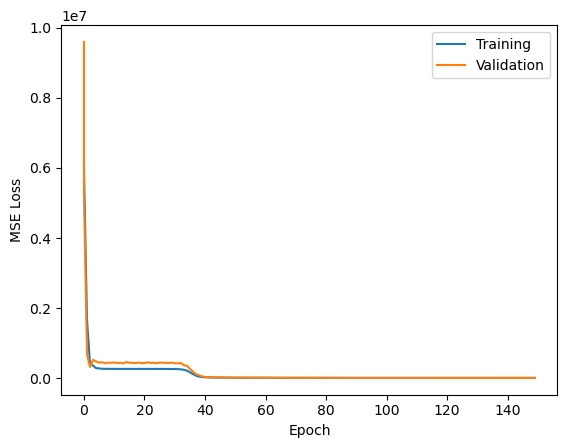

In [445]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))], 
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("MSE Loss") 
plt.xlabel("Epoch") 
plt.show()

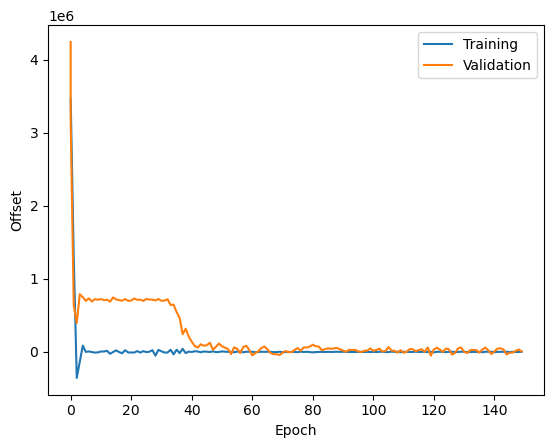

In [446]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_offset"]))],
         results["train_offset"][np.logical_not(np.isnan(results["train_offset"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_offset"]))], 
         results["val_offset"][np.logical_not(np.isnan(results["val_offset"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("Offset") 
plt.xlabel("Epoch") 
plt.show()

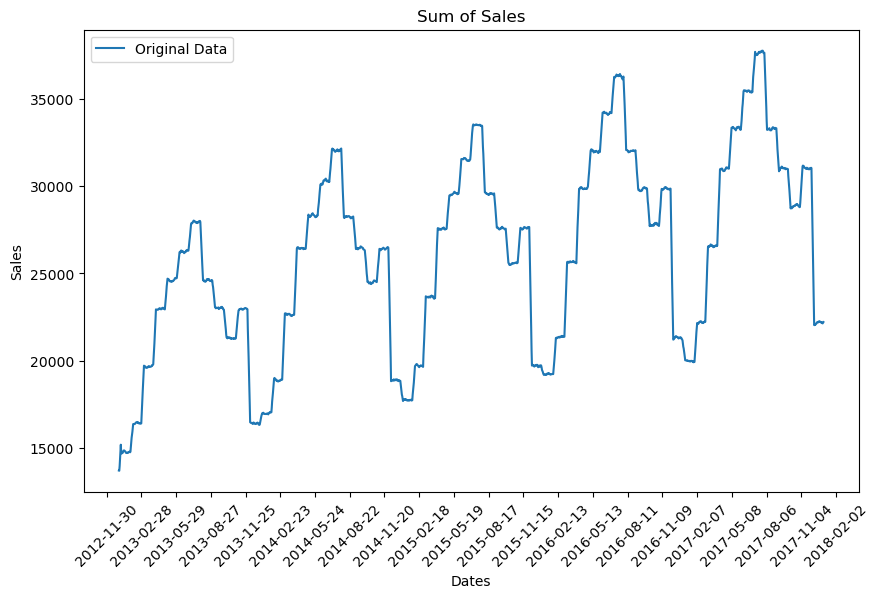

In [458]:
# Lets me crop the data to look at it
df_plot_data = df_avg[:]

# Assuming df's index is the date and the rest of the columns are integers
summed_values = df_plot_data.sum(axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_plot_data.index, summed_values, label='Original Data')

plt.xlabel('Dates')
plt.ylabel('Sales')
plt.title('Sum of Sales')
plt.xticks(rotation=45)

# Formatting date on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90)) # 3months

plt.legend()
plt.show()

In [473]:
data_set = df_avg[:].values
data_pred = df_avg[-300:-150].values

for i in range(30):
    tensor_input = torch.tensor(data_pred, dtype=torch.float32).unsqueeze(0)
    pred = model.predict(tensor_input)
    pred = pred.detach().numpy()
    data_pred = np.append(data_pred[1:], pred.reshape(1, -1), axis=0)


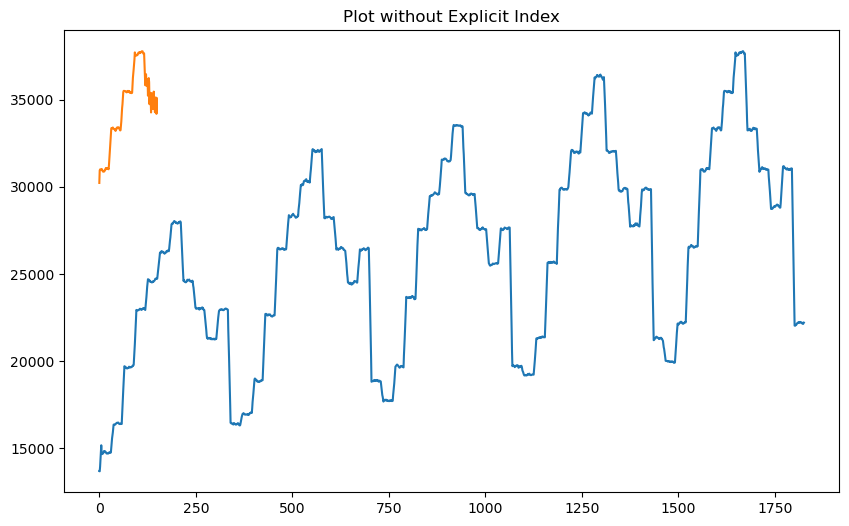

In [474]:
data_set_summed = data_set.sum(axis=1)
data_set_pred = data_pred.sum(axis=1)


# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data_set_summed)
plt.plot(data_set_pred)
plt.title('Plot without Explicit Index')
plt.show()